## Importing dependencies

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import explained_variance_score, max_error, mean_absolute_error, mean_squared_error

from tensorflow import keras

## Loading data

In [3]:
d2_files = ['DiamondData/Diamonds2/data_cushion.csv', 'DiamondData/Diamonds2/data_emerald.csv', 'DiamondData/Diamonds2/data_heart.csv',
            'DiamondData/Diamonds2/data_marquise.csv', 'DiamondData/Diamonds2/data_oval.csv', 'DiamondData/Diamonds2/data_pear.csv', 
            'DiamondData/Diamonds2/data_princess.csv', 'DiamondData/Diamonds2/data_round.csv']
df_d2 = pd.concat((pd.read_csv(f) for f in d2_files))
df_d2.head(3)


,Id,Shape,Weight,Clarity,Colour,Cut,Polish,Symmetry,Fluorescence,Messurements,Price
0,1638147,CUSHION,0.55,SI2,E,EX,EX,VG,N,5.05-4.35×2.94,"1,378.65"
1,1630155,CUSHION,0.50,VVS1,FANCY,EX,EX,VG,F,4.60-4.31×2.92,"1,379.74"
2,1612606,CUSHION,0.51,VS2,H,EX,EX,VG,N,4.71-4.35×2.94,"1,380.19"


# Preprocessing

In [4]:
df_d2.duplicated(subset='Id').sum()

349

In [5]:
df_d2.drop_duplicates(subset='Id');

#### Removing NaN values

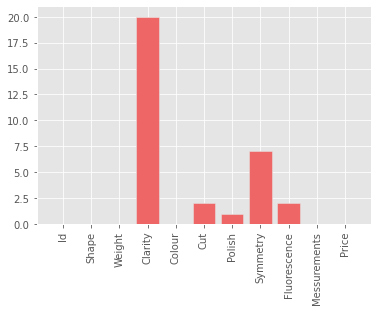

In [6]:
# Checking and removing rows containing nan values
with plt.style.context('ggplot'):
    plt.bar(df_d2.columns.to_list(), df_d2.isna().sum().to_list(), edgecolor='#E6E6E6', color='#EE6666')
    plt.xticks(rotation=90)
    plt.show()

In [7]:
df_d2.dropna(inplace=True)

#### Converting datatypes

In [8]:
# Converting the price to a float
df_d2.Price = df_d2.Price.str.replace(',', '').astype(float)
df_d2.dtypes

Id               object
Shape            object
Weight          float64
Clarity          object
Colour           object
Cut              object
Polish           object
Symmetry         object
Fluorescence     object
Messurements     object
Price           float64
dtype: object

In [9]:
# Removing 'mm' from messurements column
df_d2.Messurements = df_d2.Messurements.str.replace('mm', '')

# Splitting the dimensions of measurements in multiple columns
df_d2[['m1', 'm2', 'm3']] = df_d2['Messurements'].str.split(r"x|X|-|×| – ", expand=True)
df_d2[['m1', 'm2', 'm3']] = df_d2[['m1', 'm2', 'm3']].astype(float)
df_d2.head(3)

,Id,Shape,Weight,Clarity,Colour,Cut,Polish,Symmetry,Fluorescence,Messurements,Price,m1,m2,m3
0,1638147,CUSHION,0.55,SI2,E,EX,EX,VG,N,5.05-4.35×2.94,1378.65,5.05,4.35,2.94
1,1630155,CUSHION,0.50,VVS1,FANCY,EX,EX,VG,F,4.60-4.31×2.92,1379.74,4.60,4.31,2.92
2,1612606,CUSHION,0.51,VS2,H,EX,EX,VG,N,4.71-4.35×2.94,1380.19,4.71,4.35,2.94


#### Transforming the categorical values into numerical values

In [10]:
onehotencoder = OneHotEncoder()
X = onehotencoder.fit_transform(np.array(df_d2['Shape']).reshape(len(df_d2), 1)).toarray()
df_d2[['Cushion', 'Emerald', 'Heart', 'Marquise', 'Oval', 'Pear', 'Princess', 'Round']] = pd.DataFrame(X, index=df_d2.index)
df_d2.head(3)

,Id,Shape,Weight,Clarity,Colour,Cut,Polish,Symmetry,Fluorescence,Messurements,...,m2,m3,Cushion,Emerald,Heart,Marquise,Oval,Pear,Princess,Round
0,1638147,CUSHION,0.55,SI2,E,EX,EX,VG,N,5.05-4.35×2.94,...,4.35,2.94,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1630155,CUSHION,0.50,VVS1,FANCY,EX,EX,VG,F,4.60-4.31×2.92,...,4.31,2.92,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1612606,CUSHION,0.51,VS2,H,EX,EX,VG,N,4.71-4.35×2.94,...,4.35,2.94,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
clarity_order = ['FL', 'IF', 'VVS1', 'VVS2', 'VS1', 'VS2', 'SI1', 'SI2', 'SI3', 'I1', 'I2', 'I3']
colour_order = ['D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'O-P', 'Q-R', 'S-T', 'U-V', 'W', 'W-X', 'Y-Z', 'FANCY']
cut_order = ['F', 'GD', 'VG', 'EX']
polish_order = ['F', 'GD', 'VG', 'EX']
symmetry_order = ['FR', 'GD', 'VG', 'EX']
fluorescence_order = ['N', 'F', 'VSL', 'M', 'SL', 'ST', 'VS']

df_d2['Clarity_Score'] = df_d2.Clarity.apply(lambda x: clarity_order.index(x))
df_d2['Colour_Score'] = df_d2.Colour.apply(lambda x: colour_order.index(x))
df_d2['Cut_Score'] = df_d2.Cut.apply(lambda x: cut_order.index(x))
df_d2['Polish_Score'] = df_d2.Polish.apply(lambda x: polish_order.index(x))
df_d2['Symmetry_Score'] = df_d2.Symmetry.apply(lambda x: symmetry_order.index(x))
df_d2['Fluorescence_Score'] = df_d2.Fluorescence.apply(lambda x: fluorescence_order.index(x))
df_d2.head(3)

,Id,Shape,Weight,Clarity,Colour,Cut,Polish,Symmetry,Fluorescence,Messurements,...,Oval,Pear,Princess,Round,Clarity_Score,Colour_Score,Cut_Score,Polish_Score,Symmetry_Score,Fluorescence_Score
0,1638147,CUSHION,0.55,SI2,E,EX,EX,VG,N,5.05-4.35×2.94,...,0.0,0.0,0.0,0.0,7,1,3,3,2,0
1,1630155,CUSHION,0.50,VVS1,FANCY,EX,EX,VG,F,4.60-4.31×2.92,...,0.0,0.0,0.0,0.0,2,19,3,3,2,1
2,1612606,CUSHION,0.51,VS2,H,EX,EX,VG,N,4.71-4.35×2.94,...,0.0,0.0,0.0,0.0,5,4,3,3,2,0


## Exploratory analysis

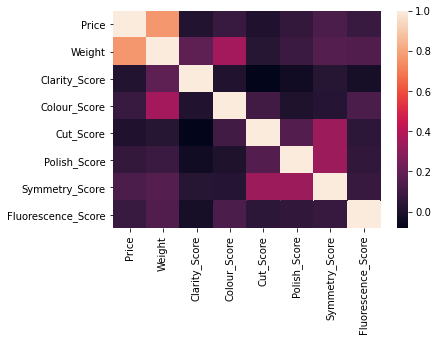

In [12]:
correlation_matrix = df_d2[['Price', 'Weight', 'Clarity_Score', 'Colour_Score', 'Cut_Score', 'Polish_Score', 'Symmetry_Score', 'Fluorescence_Score']].corr()
sns.heatmap(correlation_matrix)
plt.show()

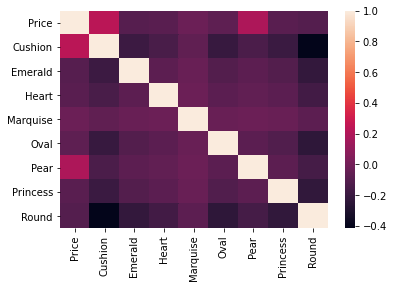

In [13]:
correlation_matrix = df_d2[['Price', 'Cushion', 'Emerald', 'Heart', 'Marquise', 'Oval', 'Pear', 'Princess', 'Round']].corr()
sns.heatmap(correlation_matrix)
plt.show()

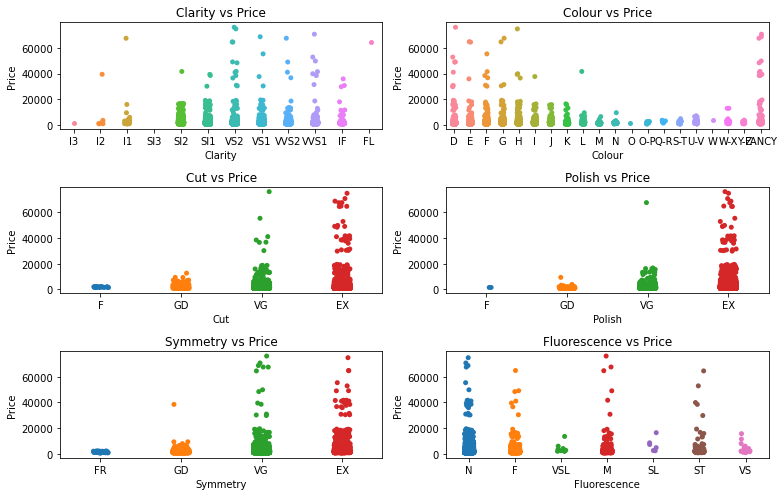

In [14]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(11, 7))

axs[0, 0].set_title("Clarity vs Price")
sns.stripplot(ax=axs[0, 0], x="Clarity", y="Price", data=df_d2, order=['I3', 'I2', 'I1', 'SI3', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF', 'FL'])

axs[0, 1].set_title("Colour vs Price")
sns.stripplot(ax=axs[0, 1], x="Colour", y="Price", data=df_d2, order=['D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'O-P', 'Q-R', 'S-T', 'U-V', 'W', 'W-X', 'Y-Z', 'FANCY'])

axs[1, 0].set_title("Cut vs Price")
sns.stripplot(ax=axs[1, 0], x="Cut", y="Price", data=df_d2, order=['F', 'GD', 'VG', 'EX'])

axs[1, 1].set_title("Polish vs Price")
sns.stripplot(ax=axs[1, 1], x="Polish", y="Price", data=df_d2, order=['F', 'GD', 'VG', 'EX'])

axs[2, 0].set_title("Symmetry vs Price")
sns.stripplot(ax=axs[2, 0], x="Symmetry", y="Price", data=df_d2, order=['FR', 'GD', 'VG', 'EX'])

axs[2, 1].set_title("Fluorescence vs Price")
sns.stripplot(ax=axs[2, 1], x="Fluorescence", y="Price", data=df_d2, order=['N', 'F', 'VSL', 'M', 'SL', 'ST', 'VS'])

fig.tight_layout()
plt.show()

Fluorescence does not appear to have any obvious correlation with the price. After searching online, fluorescence is often merely an identifying characteristic and not necessarily desirable or not. However, in some cases, fluorescence can improve the colour of a diamond or give it a hazy look which is less desirable. Because fluorescence appears to be very opinion-based, it has been ignored for training.

## Splitting in test and train

In [15]:
df_d2_numerical = df_d2[['Id', 'Price', 'Weight', 'Clarity_Score', 'Colour_Score', 'Cut_Score', 'Polish_Score', 'Symmetry_Score', 'Cushion', 'Emerald', 'Heart', 'Marquise', 'Oval', 'Pear', 'Princess', 'Round']] #
train, test = train_test_split(df_d2_numerical, test_size=0.2)

## Random forest regression

In [16]:
# Split the data for predicting the price variable
train_X = train.loc[:, ~train.columns.isin(['Price','Id'])]
train_y = train['Price']
test_X = test.loc[:, ~test.columns.isin(['Price','Id'])]
test_y = test['Price']

In [17]:
# Training the RFR model
regrRFR = RandomForestRegressor(random_state=None,  oob_score=True)
regrRFR.fit(train_X, train_y);

In [18]:
# Testing the RFR model
test_y_pred = regrRFR.predict(test_X)

explained_var = explained_variance_score(test_y, test_y_pred)
max_error_score = max_error(test_y, test_y_pred)
ms_error_score = mean_squared_error(test_y, test_y_pred)

for true, pred in zip(test_y.iloc[:5], test_y_pred[:5]):
    print('Actual price:', true, '   ->   Predicted price:', round(pred,2))

print('\nAccuracy for Train:', regrRFR.score(train_X, train_y))
print('Accuracy for Test:', regrRFR.score(test_X, test_y))
print('\nExplained variance: ', explained_var)
print('Max error: ', max_error_score)
print('Mean Absolute Error:', round(mean_absolute_error(test_y, test_y_pred), 2))
print('Mean Squared Error:', round(mean_squared_error(test_y, test_y_pred), 2))


Actual price: 794.37    ->   Predicted price: 825.94
Actual price: 1000.72    ->   Predicted price: 1035.52
Actual price: 2853.96    ->   Predicted price: 3409.26
Actual price: 2366.59    ->   Predicted price: 2469.05
Actual price: 1275.07    ->   Predicted price: 1284.84

Accuracy for Train: 0.9779480174216684
Accuracy for Test: 0.9347749702540422

Explained variance:  0.934803022839604
Max error:  16423.78740000001
Mean Absolute Error: 227.5
Mean Squared Error: 851687.98


## Visualising results

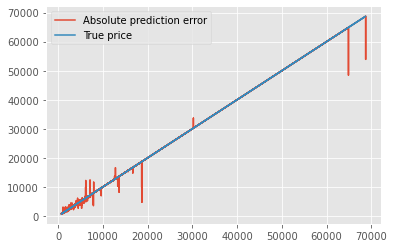

In [19]:
with plt.style.context('ggplot'):
    test_y2 = np.array([[y,y,y] for y in test_y]).flatten()
    test_y_pred2 = np.array([[y,ypred,y] for y, ypred in zip(test_y, test_y_pred)]).flatten()
    plt.plot(test_y2, test_y_pred2, label='Absolute prediction error')
    plt.plot(test_y, test_y, label='True price')
    plt.legend()
    plt.show()

### Finding origin of bad predicitions

In [20]:
train_y_pred = regrRFR.predict(train_X)

train_true_Vs_pred_df = pd.DataFrame({'True price': train_y.to_list(), 'Predicted price': list(train_y_pred)})
train_true_Vs_pred_df['Absolute error'] = abs(train_true_Vs_pred_df['True price'] - train_true_Vs_pred_df['Predicted price'])
top_N_outliers = train_true_Vs_pred_df.sort_values('Absolute error', ascending=False, inplace=False)[:50]
top_N_outliers.head(5)

,True price,Predicted price,Absolute error
4608,67570.37,42165.0025,25405.3675
3989,74875.06,64515.0179,10360.0421
385,18054.65,28194.7267,10140.0767
952,41745.97,31678.0609,10067.9091
3987,7291.85,16892.8437,9600.9937


In [21]:
worst_X = train_X.iloc[train_X.index.isin(top_N_outliers.index)]
worst_y = train_y.iloc[train_y.index.isin(top_N_outliers.index)]
count_worst_shapes = worst_X[['Cushion', 'Emerald', 'Heart', 'Marquise', 'Oval', 'Pear', 'Princess', 'Round']].sum()
count_amount_shapes = train_X[['Cushion', 'Emerald', 'Heart', 'Marquise', 'Oval', 'Pear', 'Princess', 'Round']].sum()

for outlier, total, shape in zip(count_worst_shapes, count_amount_shapes, count_worst_shapes.index):
    print('{}: {:.0f}/{:.0f}. Percent: {:.2f}'.format(shape,outlier,total,(outlier/total*100)))

Cushion: 16/1320. Percent: 1.21
Emerald: 6/465. Percent: 1.29
Heart: 2/279. Percent: 0.72
Marquise: 0/45. Percent: 0.00
Oval: 5/539. Percent: 0.93
Pear: 3/267. Percent: 1.12
Princess: 5/493. Percent: 1.01
Round: 15/1640. Percent: 0.91


The cushion and round shape of the diamond are predicted wrong more frequently, but also have more data entries. When looking at the ratio of false predictions and training instances, then the Marquise and Heart shapes are performing the worst. Marquise most likely had too little data entries to fine-tune the predictions for that shape.

## Simple neural network

In [125]:
# scaling train and test data
train_scaler = StandardScaler()
train_scaler.fit(train.loc[:, train.columns != 'Id'])

train_scaled = train_scaler.transform(train.loc[:, train.columns != 'Id'])
train_X_scaled = np.delete(train_scaled, 0, axis=1)
train_y_scaled = train_scaled[:,0]


test_scaler = StandardScaler()
test_scaler.fit(test.loc[:, test.columns != 'Id'])

test_scaled = test_scaler.transform(test.loc[:, test.columns != 'Id'])
test_X_scaled = np.delete(test_scaled, 0, axis=1)
test_y_scaled = test_scaled[:,0]


In [115]:
# Building model
model = keras.Sequential()
model.add(keras.layers.Dense(units=50, activation='sigmoid', input_dim=train_X_scaled.shape[1]))
model.add(keras.layers.Dense(units=100, activation='sigmoid'))
model.add(keras.layers.Dense(units=100, activation='sigmoid', kernel_regularizer='l2'))
model.add(keras.layers.Dense(units=100, activation='sigmoid'))
model.add(keras.layers.Dense(1, activation='linear'))

model.compile(optimizer='adam', loss="mse", metrics='mae')
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_52 (Dense)             (None, 50)                750       
_________________________________________________________________
dense_53 (Dense)             (None, 100)               5100      
_________________________________________________________________
dense_54 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_55 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_56 (Dense)             (None, 1)                 101       
Total params: 26,151
Trainable params: 26,151
Non-trainable params: 0
_________________________________________________________________


In [116]:
history = model.fit(train_X_scaled, train_y_scaled, validation_data=(test_X_scaled, test_y_scaled), epochs=500, batch_size=20)

Epoch 1/500
253/253 [==============================] - 1s 2ms/step - loss: 1.2941 - mae: 0.3440 - val_loss: 0.9306 - val_mae: 0.3215
Epoch 2/500
253/253 [==============================] - 1s 2ms/step - loss: 0.6850 - mae: 0.2484 - val_loss: 0.5786 - val_mae: 0.1631
Epoch 3/500
253/253 [==============================] - 1s 2ms/step - loss: 0.4270 - mae: 0.1744 - val_loss: 0.4502 - val_mae: 0.1584
Epoch 4/500
253/253 [==============================] - 0s 2ms/step - loss: 0.3392 - mae: 0.1627 - val_loss: 0.3626 - val_mae: 0.1368
Epoch 5/500
253/253 [==============================] - 0s 2ms/step - loss: 0.2941 - mae: 0.1609 - val_loss: 0.3156 - val_mae: 0.1484
Epoch 6/500
253/253 [==============================] - 0s 2ms/step - loss: 0.2721 - mae: 0.1650 - val_loss: 0.3011 - val_mae: 0.1422
Epoch 7/500
253/253 [==============================] - 0s 2ms/step - loss: 0.2383 - mae: 0.1516 - val_loss: 0.2605 - val_mae: 0.1316
Epoch 8/500
253/253 [==============================] - 0s 2ms/step - 

In [130]:
# Optional: load existing model
model = keras.models.load_model('models/model_50_100_100_ep=1000_batch=20_adam_mse_l2_middle_layer')

OSError: SavedModel file does not exist at: models/model_50_100_100_ep=1000_batch=20_adam_mse_l2_middle_layer/{saved_model.pbtxt|saved_model.pb}

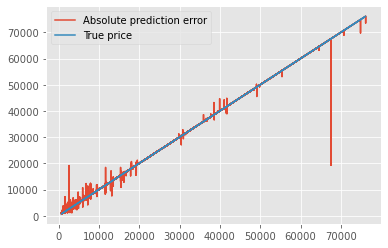

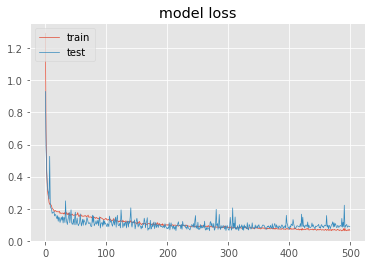

In [126]:
train_y_pred = model.predict(train_X_scaled)
train_with_predictions_scaled = np.insert(train_X_scaled, 0, train_y_pred.flatten(), axis=1)
train_with_predictions = train_scaler.inverse_transform(train_with_predictions_scaled)
train_y_pred = train_with_predictions[:,0]

with plt.style.context('ggplot'):
    train_y2 = np.array([[y,y,y] for y in train_y]).flatten()
    train_y_pred2 = np.array([[y,ypred,y] for y, ypred in zip(train_y, train_y_pred)]).flatten()
    plt.plot(train_y2, train_y_pred2, label='Absolute prediction error')
    plt.plot(train_y, train_y, label='True price')
    plt.legend()
    plt.show()

plt.clf()
with plt.style.context('ggplot'):
    plt.plot(history.history['loss'], linewidth=0.7)
    plt.plot(history.history['val_loss'], linewidth=0.7)
    plt.title('model loss')
    plt.legend(['train', 'test'], loc='upper left')

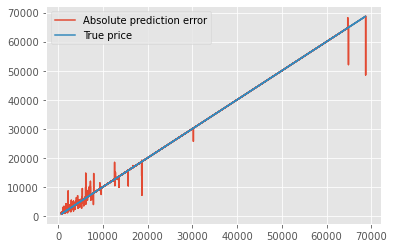

In [127]:
test_y_pred = model.predict(test_X_scaled)
test_with_predictions_scaled = np.insert(test_X_scaled, 0, test_y_pred.flatten(), axis=1)
test_with_predictions = test_scaler.inverse_transform(test_with_predictions_scaled)
test_y_pred = test_with_predictions[:,0]

with plt.style.context('ggplot'):
    test_y2 = np.array([[y,y,y] for y in test_y]).flatten()
    test_y_pred2 = np.array([[y,ypred,y] for y, ypred in zip(test_y, test_y_pred)]).flatten()
    plt.plot(test_y2, test_y_pred2, label='Absolute prediction error')
    plt.plot(test_y, test_y, label='True price')
    plt.legend()
    plt.show()

In [81]:
explained_var = explained_variance_score(test_y, test_y_pred)
max_error_score = max_error(test_y, test_y_pred)

for true, pred in zip(test_y[:5], test_y_pred[:5]):
    print('Actual price:', true, '   ->   Predicted price:', round(pred,2))

print('\nExplained variance: ', explained_var)
print('Max error: ', max_error_score)
print('Mean Absolute Error:', round(mean_absolute_error(test_y, test_y_pred), 2))
print('Mean Squared Error:', round(mean_squared_error(test_y, test_y_pred), 2))

Actual price: 794.37    ->   Predicted price: 1120.1
Actual price: 1000.72    ->   Predicted price: 1100.83
Actual price: 2853.96    ->   Predicted price: 3401.88
Actual price: 2366.59    ->   Predicted price: 2364.73
Actual price: 1275.07    ->   Predicted price: 1284.36

Explained variance:  0.9201618833799619
Max error:  17465.661080227714
Mean Absolute Error: 364.79
Mean Squared Error: 1061042.17


In [131]:
model.save('models/model_50_100_100_ep=1000_batch=20_adam_mse_l2_middle_layer')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/model_50_100_100_ep=1000_batch=20_adam_mse_l2_middle_layer\assets
